In [1]:
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
strict = pd.read_csv(
    "blast_strict.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)

medium = pd.read_csv(
    "blast_medium.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)

lenient = pd.read_csv(
    "blast_lenient.homologous_pairs.tsv",
    sep=r"\s+",
    header=None,
    engine="python"
)
strict.head()

,0,1,2
0,Al_scaffold_0001_1000,scaffold_101081.1,187
1,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_1003897,375
2,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_6002203,376
3,Al_scaffold_0001_1004,fgenesh1_pm.C_scaffold_6001283,334
4,Al_scaffold_0001_1004,fgenesh2_kg.2__1087__AT1G68380.1,336


In [4]:
strict.columns = medium.columns = lenient.columns = [
    "query_id",
    "subject_id",
    "value"
]
strict.head()

,query_id,subject_id,value
0,Al_scaffold_0001_1000,scaffold_101081.1,187
1,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_1003897,375
2,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_6002203,376
3,Al_scaffold_0001_1004,fgenesh1_pm.C_scaffold_6001283,334
4,Al_scaffold_0001_1004,fgenesh2_kg.2__1087__AT1G68380.1,336


In [8]:
def clean_df(df):
    # convert value column to numeric; invalid values (e.g., 'bitScore') become NaN
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    # drop rows where value is NaN (this removes the header row if it was read as data)
    df = df.dropna(subset=["value"]).copy()
    # enforce correct dtypes
    df["query_id"] = df["query_id"].astype(str)
    df["subject_id"] = df["subject_id"].astype(str)
    df["value"] = df["value"].astype(float)
    return df

strict  = clean_df(strict)
medium  = clean_df(medium)
lenient = clean_df(lenient)

print(strict.shape, medium.shape, lenient.shape)
strict.head()


(46036, 3) (150643, 3) (216669, 3)


,query_id,subject_id,value
0,Al_scaffold_0001_1000,scaffold_101081.1,187.0
1,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_1003897,375.0
2,Al_scaffold_0001_1004,fgenesh1_pg.C_scaffold_6002203,376.0
3,Al_scaffold_0001_1004,fgenesh1_pm.C_scaffold_6001283,334.0
4,Al_scaffold_0001_1004,fgenesh2_kg.2__1087__AT1G68380.1,336.0


In [9]:
def walktrap_clustering(df: pd.DataFrame):
    # safety cleaning inside the function
    df = df.copy()
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["value"])

    edges = list(zip(df["query_id"].astype(str), df["subject_id"].astype(str)))
    weights = df["value"].astype(float).tolist()

    g = ig.Graph.TupleList(edges, directed=False)
    g.es["weight"] = weights

    g.simplify(multiple=True, loops=True, combine_edges={"weight": "max"})

    wt = g.community_walktrap(weights="weight")
    clustering = wt.as_clustering()

    sizes = clustering.sizes()
    fam_df = pd.DataFrame({
        "family_id": range(len(sizes)),
        "family_size": sizes
    }).sort_values("family_size", ascending=False).reset_index(drop=True)

    summary = {
        "families_total": len(sizes),
        "genes_in_graph": g.vcount(),
        "duplicated_genes_(family_size>=2)": sum(s for s in sizes if s >= 2),
        "singletons_(family_size==1)": sum(1 for s in sizes if s == 1),
        "max_family_size": max(sizes) if sizes else 0,
        "median_family_size": float(pd.Series(sizes).median()) if sizes else 0.0
    }

    return fam_df, summary


In [10]:
datasets = {"strict": strict, "medium": medium, "lenient": lenient}

walktrap_families = {}
walktrap_summary = []

for name, df in datasets.items():
    print(f"Running walktrap for {name} (edges={len(df)})")
    fam_df, summary = walktrap_clustering(df)
    walktrap_families[name] = fam_df
    walktrap_summary.append({"dataset": name, **summary})

walktrap_summary_df = pd.DataFrame(walktrap_summary)
walktrap_summary_df


Running walktrap for strict (edges=46036)
Running walktrap for medium (edges=150643)
Running walktrap for lenient (edges=216669)


,dataset,families_total,genes_in_graph,duplicated_genes_(family_size>=2),singletons_(family_size==1),max_family_size,median_family_size
0,strict,4744,17932,17932,0,123,2.0
1,medium,5145,22578,22288,290,523,2.0
2,lenient,5118,24111,23805,306,684,3.0


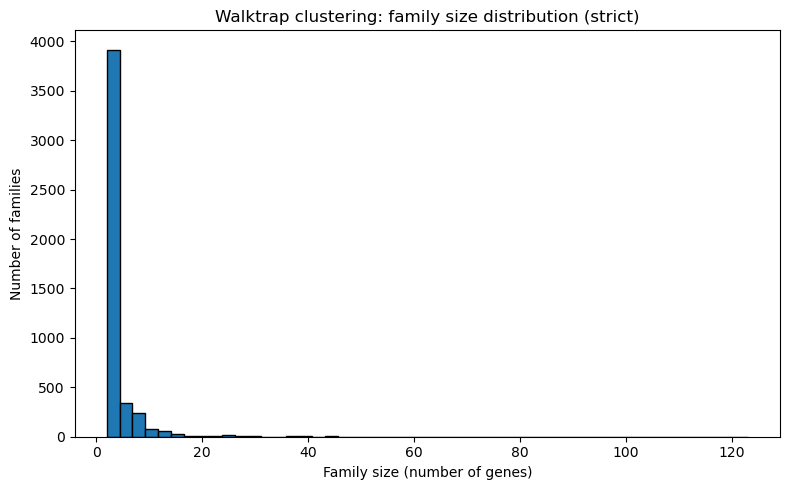

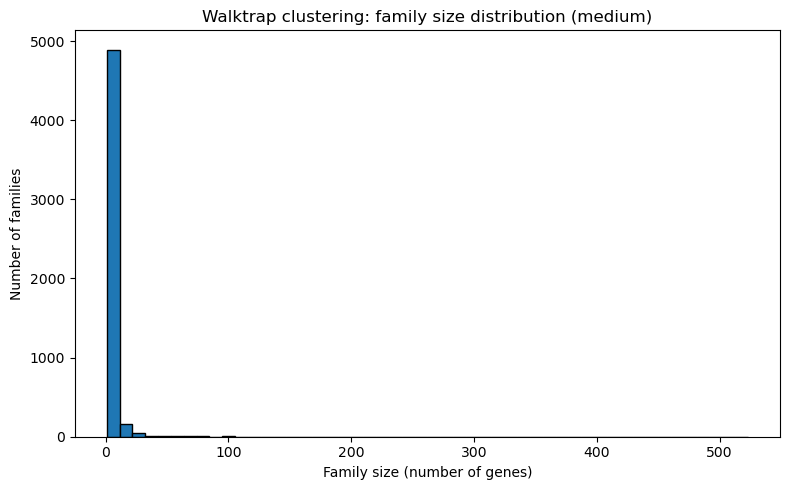

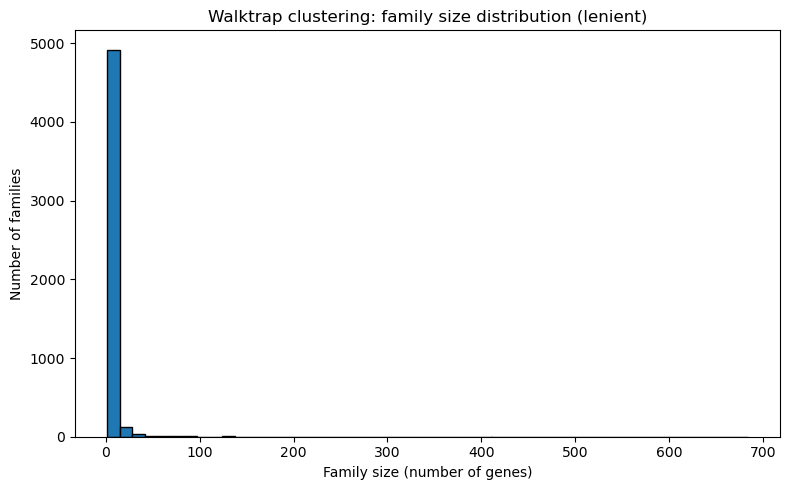

In [11]:
import matplotlib.pyplot as plt

for name, fam_df in walktrap_families.items():
    plt.figure(figsize=(8, 5))
    plt.hist(fam_df["family_size"], bins=50, edgecolor="black")
    plt.title(f"Walktrap clustering: family size distribution ({name})")
    plt.xlabel("Family size (number of genes)")
    plt.ylabel("Number of families")
    plt.tight_layout()
    plt.show()
